In [1]:
%matplotlib inline


import librosa
import librosa.display

import pandas
import numpy
import sklearn
import sklearn.model_selection

import IPython

import matplotlib.pyplot as plt

In [2]:
labels = pandas.read_csv('data/ff1010bird.labels.csv', index_col='itemid')
labels.head(3)

,datasetid,hasbird
itemid,,
64486,ff1010bird,0
2525,ff1010bird,0
44981,ff1010bird,0


In [3]:
len(labels), labels.hasbird.mean()

(7690, 0.2516254876462939)

In [4]:
pos = labels[labels.hasbird == 1].head(10)
neg = labels[labels.hasbird == 0].head(10)
v = neg.index.values
'{{{}}}'.format(','.join(str(i) for i in v))

'{64486,2525,44981,101323,165746,38232,104540,157473,132129,127302}'

In [5]:
def features(wavpath):
    y, sr = librosa.load(wavpath, offset=0)
    print(sr)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_fft=2048, hop_length=512, n_mfcc=20)
    mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=64, fmin=500, fmax=8000)
    return mel

def plot_mfcc(mfcc):
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mfcc, x_axis='time')
    plt.colorbar()
    plt.title('MFCC')
    plt.tight_layout()
    
def plot_melspectrogram(S, title='Mel spectrogram', fmax=8000):
    plt.figure(figsize=(10, 4))
    d = librosa.power_to_db(S, ref=numpy.max)
    librosa.display.specshow(d, y_axis='mel', x_axis='time', fmin=500, fmax=fmax)
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.tight_layout()


19037 64486
22050
22050


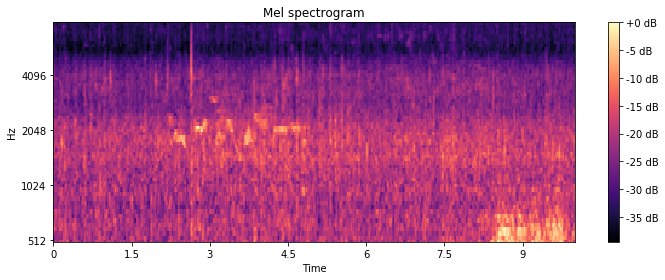

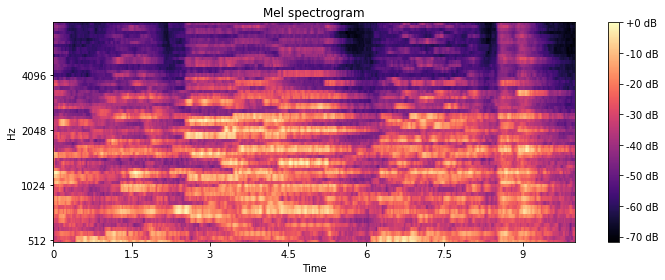

In [6]:
p = pos.index.values[0]
n = neg.index.values[0]
print(p, n)
p = features('data/ff1010bird/{}.wav'.format(p))
n = features('data/ff1010bird/{}.wav'.format(n))

#plot_mfcc(p)
#plot_mfcc(n)
plot_melspectrogram(p)
plot_melspectrogram(n)

IPython.display.Audio('data/ff1010bird/{}.wav'.format(pos.index.values[0]))

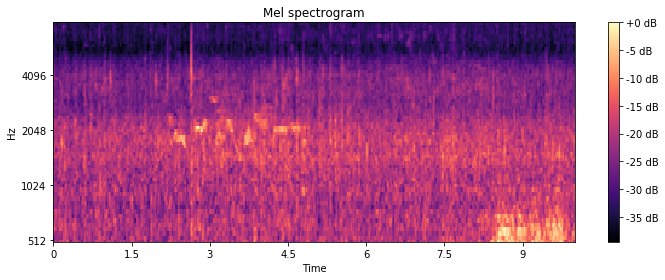

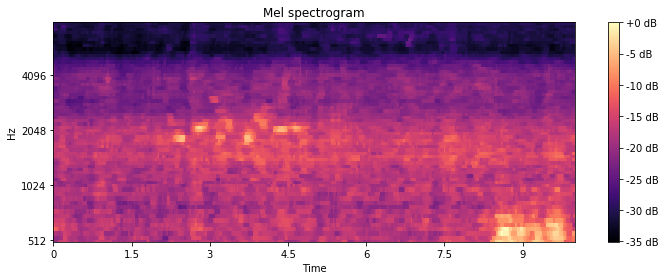

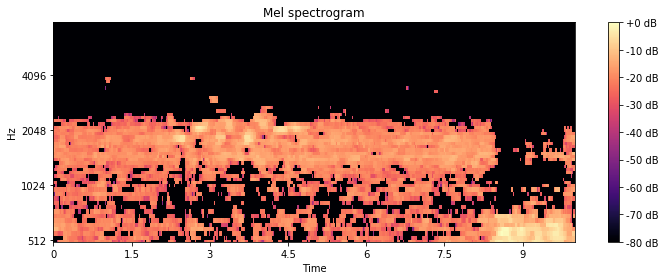

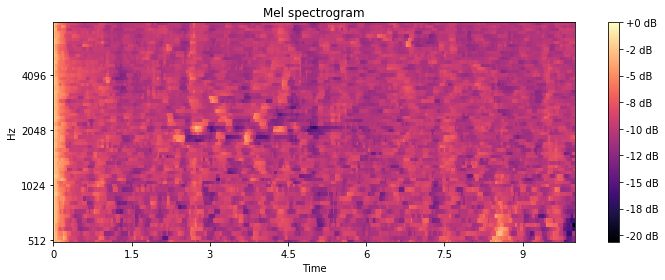

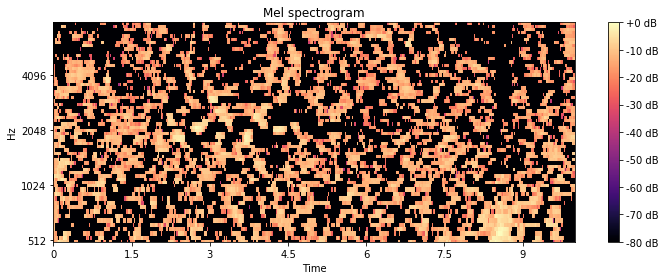

In [7]:
from scipy import ndimage
from scipy import signal
plot_melspectrogram(p)
dp = ndimage.median_filter(p, (1, 7))
plot_melspectrogram(dp)

def meann(s):
    return s - (numpy.mean(s, axis=0) + 1e-8)

dpnm = meann(dp)
plot_melspectrogram(dpnm)

dpen = librosa.core.pcen(dp, power=0.5, time_constant=0.4)
plot_melspectrogram(dpen)

penm = meann(dpen)
plot_melspectrogram(penm)

fft (2048,)
(1025,)


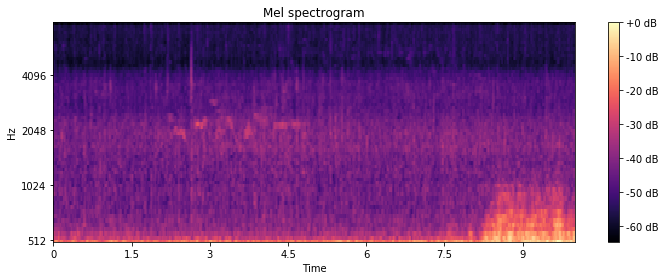

In [8]:
import librosa.util
import detectbirds

def spectrogram(y, window='hamming', win_length=None, n_fft=2048, hop_length=None, center=True, pad_mode='reflect', power=2):
    np = numpy
    
    if win_length is None:
        win_length = n_fft

    if hop_length is None:
        hop_length = int(win_length // 4)
        
    fft_window = librosa.filters.get_window(window, win_length, fftbins=True)
    fft_window = librosa.util.pad_center(fft_window, n_fft)
    #fft_window = fft_window.reshape((-1, 1))
    print('fft', fft_window.shape)
    
    #frames = librosa.util.frame(y)
    #frames.shape
    
    if center:
        y = np.pad(y, int(n_fft // 2), mode=pad_mode)
    
    y_frames = librosa.util.frame(y, frame_length=n_fft, hop_length=hop_length)

    mel_filters = librosa.filters.mel(sr=20050, n_fft=2048, n_mels=64)
    
    # Pre-allocate output matrix
    #frequencies = np.arange(0, 20050, (n_fft//2+1))
    frequencies = librosa.fft_frequencies(sr=20050, n_fft=2048)
    
    print(frequencies.shape)
    #print('freqs', frequencies)
    spectrogram = np.empty((frequencies.shape[0], y_frames.shape[1]), dtype=np.float32, order='F')

    #print(y_frames.shape)
    #print(spectrogram.shape)

    #print('one', y_frames[:,0].shape)
    
    for frameno in range(0, y_frames.shape[1]):
        #s = fft.fft(fft_window * y_frames[:, bl_s:bl_t], axis=0)[:stft_matrix.shape[0]]
        w = fft_window * y_frames[:,frameno]

        # TODO: let C++ function take numpy arrays to avoid list conversion and loop
        l = list(w)
        for i, freq in enumerate(frequencies):
            spectrogram[i,frameno] = detectbirds.goertzel(l, int(freq), int(20050))
        

    return mel_filters.dot(spectrogram**power)
    
#for frameno in range(0, frames.shape[]):
#    print(frames[, :].shape)



y, sr = librosa.load('data/ff1010bird/{}.wav'.format(19037), offset=0)
s = spectrogram(y)

plot_melspectrogram(s)


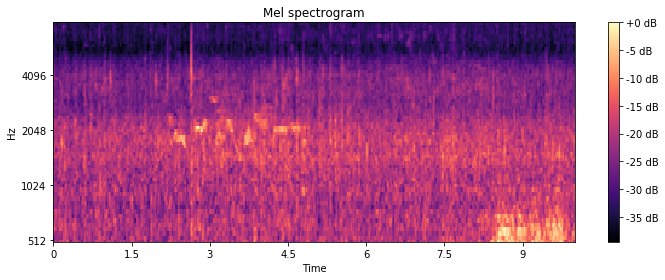

In [9]:
plot_melspectrogram(p)

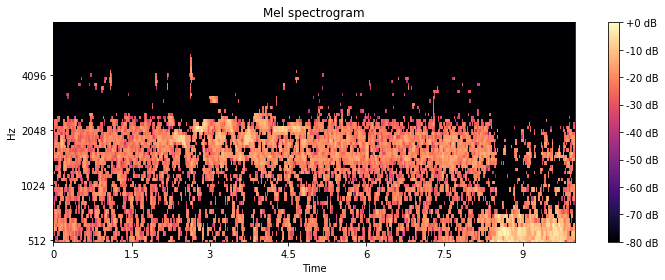

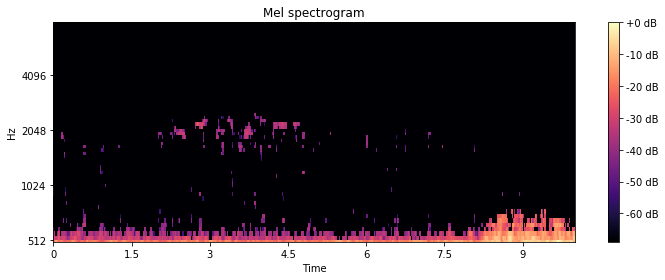

In [10]:
pm = meann(p)
plot_melspectrogram(pm)
gm = meann(s)
plot_melspectrogram(gm)

In [11]:
librosa.filters.mel(sr=20050, n_fft=2048, n_mels=40).shape

(40, 1025)